# Figures for the paper

In [1]:
# first figure(s) created to explain conformal prediction
# some imports
import matplotlib.pyplot as plt
import numpy as np
import openml
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# local library
from common import load_and_preprocess_openml_task, plot_confidence_intervals, plot_pareto, translations

# settings for seaborn
sns.set_style("darkgrid")

# hard-coded values
random_seed = 42

In [2]:
# prepare data
task_id = 361234
df_X, df_y, task = load_and_preprocess_openml_task(task_id)
X = df_X.values
y = df_y.values
X_prop_train, X_test, y_prop_train, y_test = train_test_split(X, y, test_size=0.5, 
                                                            shuffle=True, random_state=random_seed)
X_cal, X_test, y_cal, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                            shuffle=True, random_state=random_seed)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_prop_train = scaler_X.fit_transform(X_prop_train)
X_cal = scaler_X.transform(X_cal)
X_test = scaler_X.transform(X_test)

y_prop_train = scaler_y.fit_transform(y_prop_train.reshape(-1,1)).ravel()
y_cal = scaler_y.transform(y_cal.reshape(-1,1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1,1)).ravel()

print("Training set: %d samples" % X_prop_train.shape[0])
print("Calibration set: %d samples" % X_cal.shape[0])
print("Test set: %d samples" % X_test.shape[0])  

# train regressor on training set
print("Training regressor...")
regressor = RandomForestRegressor(random_state=random_seed)
regressor.fit(X_prop_train, y_prop_train)
print("Regressor trained")

C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


Training set: 2088 samples
Calibration set: 1044 samples
Test set: 1045 samples
Training regressor...
Regressor trained


In [3]:
# with the trained regressor, we can now test it on the calibration data and get the residuals
y_cal_pred = regressor.predict(X_cal)
residuals = abs(y_cal - y_cal_pred)

# get the indexes of a sorted 'residuals' array
indexes_sorted_by_residuals = np.argsort(residuals)

# take a few representative indexes (low, medium, high residuals)
sample_indexes = indexes_sorted_by_residuals[:3].tolist()
sample_indexes += indexes_sorted_by_residuals[17000:17004].tolist()
sample_indexes += indexes_sorted_by_residuals[-3:].tolist()

# actually, since we just want a pretty figure, let's do it by hand
hand_picked_indexes = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
hand_picked_indexes = [0, 200, 400, 600, 800, 1000]
sample_indexes = indexes_sorted_by_residuals[hand_picked_indexes]

print(sample_indexes)

[ 183 1033  257  851  558  681]


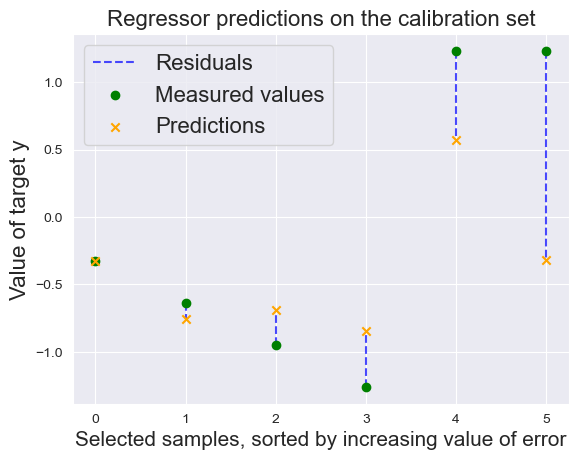

In [14]:
# plot the predictions, showing the difference
fig, ax = plt.subplots()
x = range(0,len(sample_indexes))

for i, index in enumerate(sample_indexes[:-1]) :
    ax.plot([x[i], x[i]], [y_cal[index], y_cal_pred[index]], '--', color='blue', alpha=0.7, zorder=1)
ax.plot([x[-1], x[-1]], [y_cal[sample_indexes[-1]], y_cal_pred[sample_indexes[-1]]], 
        '--', color='blue', alpha=0.7, label="Residuals", zorder=1)
    
ax.scatter(x, y_cal[sample_indexes], marker='o', color='green', label="Measured values")
ax.scatter(x, y_cal_pred[sample_indexes], marker='x', color='orange', label="Predictions")

ax.legend(loc='best', fontsize=16)
ax.set_title("Regressor predictions on the calibration set", fontsize=16)
ax.set_xlabel("Selected samples, sorted by increasing value of error", fontsize=15, wrap=True)
ax.set_ylabel("Value of target y", fontsize=16)

plt.savefig("figures/cp-example-predictions.png", dpi=300)

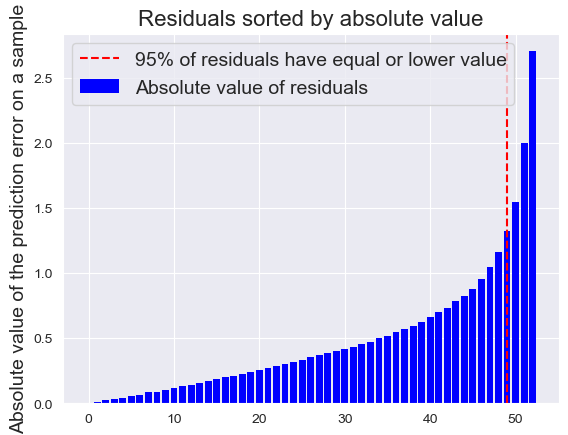

In [17]:
# now, a figure with the residulas sorted by size, and a cutting point at 0.95
fig, ax = plt.subplots()#figsize=(10,8))
sorted_residuals = np.sort(residuals)
sorted_residuals_selected = sorted_residuals[::20] # take one value every 10
x = range(0, sorted_residuals_selected.shape[0])
bars = ax.bar(x, sorted_residuals_selected, color='blue', edgecolor='none',
              label="Absolute value of residuals")
x_alpha = int(0.95 * x[-1])
ax.axvline(x_alpha, linestyle='--', color='r', label="95% of residuals have equal or lower value")
ax.set_title("Residuals sorted by absolute value", fontsize=16)
ax.set_ylabel("Absolute value of the prediction error on a sample", fontsize=14, wrap=True)
ax.legend(loc='best', fontsize=14)

plt.savefig("figures/cp-example-residuals.png", dpi=300)

Index of the value for the confidence interval: 991
Width of the confidence interval: 1.4387


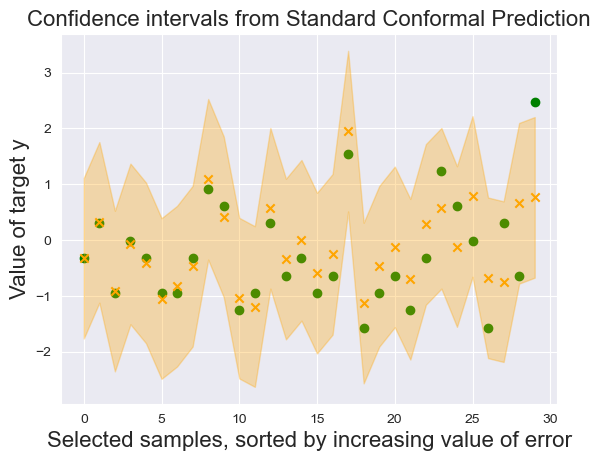

In [15]:
# and finally, create and plot the confidence intervals
ci_index = int(0.95 * sorted_residuals.shape[0])
print("Index of the value for the confidence interval: %d" % ci_index)
ci_width = sorted_residuals[ci_index]
print("Width of the confidence interval: %.4f" % ci_width)
ci = np.zeros((len(sample_indexes), 2))
for i, index in enumerate(sample_indexes) :
    ci[i,0] = y_cal_pred[index] - ci_width
    ci[i,1] = y_cal_pred[index] + ci_width
    
fig, ax = plt.subplots()
x = range(0, len(sample_indexes))
ax.scatter(x, y_cal[sample_indexes], marker='o', color='green', label="Measured values")
ax.scatter(x, y_cal_pred[sample_indexes], marker='x', color='orange', label="Predictions")

# visualize corresponding confidence intervals around point predictions
ax.fill_between(x, ci[:,0], ci[:,1], color='orange', alpha=0.3)
    
ax.set_xlabel("Selected samples, sorted by increasing value of error", fontsize=16)
ax.set_ylabel("Value of target y", fontsize=16)
ax.set_title("Confidence intervals from Standard Conformal Prediction", fontsize=16, wrap=True)

plt.savefig("figures/cp-example-confidence-intervals.png", dpi=300)


## Second attempt: horizontal figures
All the part above is nice and dandy, but it is too small for the paper. However, maybe having long, horizontal plots would work better. So, run the first cells above, then run this one.

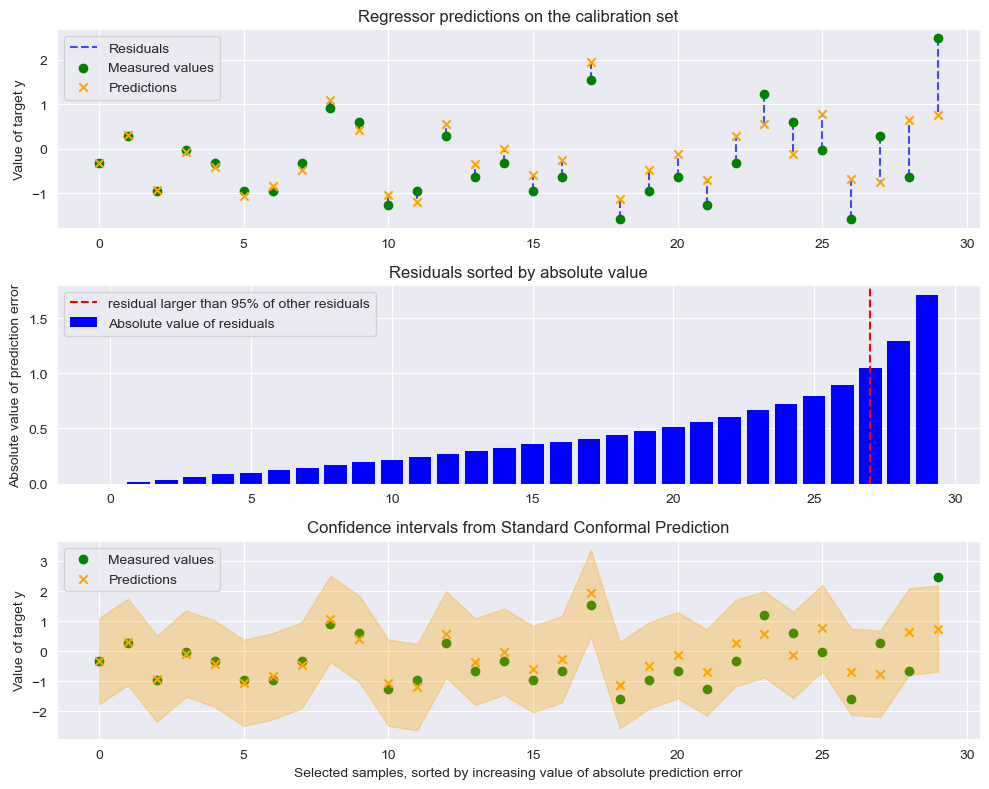

In [21]:
max_hand_picked_indexes = 30
hand_picked_indexes = [int(len(indexes_sorted_by_residuals)/max_hand_picked_indexes * i) for i in range(0, max_hand_picked_indexes)]
sample_indexes = indexes_sorted_by_residuals[hand_picked_indexes]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
# first subplot: residuals
x = range(0,len(sample_indexes))

for i, index in enumerate(sample_indexes[:-1]) :
    ax[0].plot([x[i], x[i]], [y_cal[index], y_cal_pred[index]], '--', color='blue', alpha=0.7, zorder=1)
ax[0].plot([x[-1], x[-1]], [y_cal[sample_indexes[-1]], y_cal_pred[sample_indexes[-1]]], 
        '--', color='blue', alpha=0.7, label="Residuals", zorder=1)
    
ax[0].scatter(x, y_cal[sample_indexes], marker='o', color='green', label="Measured values")
ax[0].scatter(x, y_cal_pred[sample_indexes], marker='x', color='orange', label="Predictions")

ax[0].legend(loc='best') #, fontsize=16)
ax[0].set_title("Regressor predictions on the calibration set")#, fontsize=16)
#ax[0].set_xlabel("Selected samples, sorted by increasing value of error")#, fontsize=15, wrap=True)
ax[0].set_ylabel("Value of target y")#, fontsize=16)

# second subplot: barplot with residual values
sorted_residuals_selected = residuals[sample_indexes]
bars = ax[1].bar(x, sorted_residuals_selected, color='blue', edgecolor='none',
              label="Absolute value of residuals")
x_alpha = int(0.95 * x[-1])
ax[1].axvline(x_alpha, linestyle='--', color='r', label="Residual larger than 95% of other residuals")
ax[1].set_title("Residuals sorted by absolute value")#, fontsize=16)
ax[1].set_ylabel("Absolute value of prediction error")#, fontsize=14, wrap=True)
ax[1].legend(loc='best')#, fontsize=14)

# third subplot: confidence intervals
ax[2].scatter(x, y_cal[sample_indexes], marker='o', color='green', label="Measured values")
ax[2].scatter(x, y_cal_pred[sample_indexes], marker='x', color='orange', label="Predictions")

# visualize corresponding confidence intervals around point predictions
ax[2].fill_between(x, ci[:,0], ci[:,1], color='orange', alpha=0.3)
    
ax[2].set_xlabel("Selected samples, sorted by increasing value of absolute prediction error")#, fontsize=16)
ax[2].set_ylabel("Value of target y")#, fontsize=16)
ax[2].set_title("Confidence intervals from Standard Conformal Prediction")#, fontsize=16, wrap=True)
ax[2].legend(loc='best')

# this line should automatically adjust the layout
fig.tight_layout()

# save figure
plt.savefig("figures/cp-example-horizontal.png", dpi=300)